In [169]:
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras


In [170]:
!nvidia-smi

Thu Sep 12 11:04:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              30W /  70W |   4229MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [171]:
import tensorflow as tf
from helper_functions import unzip_data, create_tensorboard_callback,plot_loss_curves,compare_historys

In [172]:
unzip_data('nlp-getting-started.zip')

In [173]:
import pandas as pd

In [174]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()
train_df["text"][1]


'Forest fire near La Ronge Sask. Canada'

In [175]:
train_df_shuffled = train_df.sample(frac=1,random_state=42)

In [176]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [177]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [178]:
len(train_df),len(test_df)

(7613, 3263)

In [179]:
import random
random_index = random.randint(0,len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
    _,text,target = row
    print(f"Target:{target}","(real disaster)" if target>0 else "(not rela disaster)")
    print(f"Text :{text}")
    print('\n')


Target:1 (real disaster)
Text :@Vickie627 Desert Storm was an unqualified victory a treaty was signed.  Under Clinton the situation only got worse and more violent. #tcot


Target:1 (real disaster)
Text :@BigSim50 nah Philly pundits are half the cause. They set buildings on fire to report on buildings being on fire.


Target:1 (real disaster)
Text :DEEP crew to help with California wild fires http://t.co/QKz2Sp06xn via @thedayct


Target:1 (real disaster)
Text :Japan Marks 70th Anniversary of Hiroshima Atomic Bombing http://t.co/93vqkdFgnr


Target:1 (real disaster)
Text :Correction: Tent Collapse Story http://t.co/jXs50FkviK




In [180]:
from sklearn.model_selection import train_test_split

train_sentences,val_sentences,train_labels,val_labels=train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                       train_df_shuffled["target"].to_numpy(),
                                                                       test_size = 0.1,
                                                                       random_state=42)


In [181]:
train_sentences[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [182]:
train_sentences

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

In [183]:
from tensorflow.keras.layers import TextVectorization

In [184]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [185]:
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    standardize="lower_and_strip_punctuation",
    split = "whitespace",
    ngrams= None,
    output_mode = 'int',
    output_sequence_length = max_length,
    pad_to_max_tokens = True,
)


In [186]:
text_vectorizer.adapt(train_sentences)

In [187]:
sample_sentence = "hello world"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1400,  107,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [188]:
random_sentence = random.choice(train_sentences)
print(random_sentence)
text_vectorizer(random_sentence)

I forgot to bring chocolate with me. Major disaster.


<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([   8, 2990,    5,  962, 4012,   14,   31,  771,   75,    0,    0,
          0,    0,    0,    0])>

In [189]:
words_in_vocabulary =  text_vectorizer.get_vocabulary()
top_5_words = words_in_vocabulary[:5]
bottom_5_words = words_in_vocabulary[-5:]
len(words_in_vocabulary),top_5_words,bottom_5_words

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

In [190]:
# from tensorflow.keras import layers

tf.random.set_seed(42)
from tensorflow.keras import layers

embeddings = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embeddings

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [191]:
random_sentence = random.choice(train_sentences)
print(random_sentence)
print("\n")
print("embedded version")
embeddings(text_vectorizer([random_sentence]))

Hey @reddit - the concept of a 'quarantine' makes no sense if the people you've quarantined can just wander out &amp; about whenever they want


embedded version


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04167025, -0.02743115, -0.03318678, ...,  0.01724483,
         -0.03393742,  0.00267086],
        [ 0.03462697, -0.04900651, -0.00038124, ...,  0.04209674,
          0.00374371, -0.00980129],
        [ 0.02528966,  0.02937907,  0.02917549, ..., -0.00096739,
          0.03150145,  0.03177052],
        ...,
        [-0.029609  , -0.01989708, -0.03568319, ..., -0.03568071,
          0.0444823 , -0.00792261],
        [-0.02944732,  0.00088232,  0.02349842, ..., -0.01810932,
          0.03597498, -0.03158206],
        [ 0.00044198, -0.02556144, -0.03317963, ..., -0.03449906,
         -0.01599319, -0.04697727]]], dtype=float32)>

In [192]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("clf",MultinomialNB()),
])

model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [193]:
baseline_score=model_0.score(val_sentences,val_labels)
baseline_score

0.7926509186351706

In [194]:
baseline_preds=model_0.predict(val_sentences)

In [195]:
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [196]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

In [197]:
def calculate_results(y_true,y_pred):
    model_accuaracy = accuracy_score(y_true,y_pred) *100
    model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_pred,average="weighted")
    model_results={
        "accuracy":model_accuaracy,
        "precision":model_precision,
        "recall":model_recall,
        "f1":model_f1
    }
    return model_results

In [198]:
baseline_results=calculate_results(val_labels,baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [199]:
from helper_functions import create_tensorboard_callback

In [200]:
SAVE_DIR='model_logs'

In [201]:
from tensorflow.keras import  layers
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embeddings(x)
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,outputs,name="model_1_dense")

In [202]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [203]:
model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [204]:
model_1.history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),callbacks=[create_tensorboard_callback(SAVE_DIR,'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20240912-110424
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6405 - loss: 0.6491 - val_accuracy: 0.7598 - val_loss: 0.5333
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8092 - loss: 0.4654 - val_accuracy: 0.7887 - val_loss: 0.4739
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8545 - loss: 0.3616 - val_accuracy: 0.7940 - val_loss: 0.4620
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8859 - loss: 0.2955 - val_accuracy: 0.7900 - val_loss: 0.4683
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9067 - loss: 0.2468 - val_accuracy: 0.7769 - val_loss: 0.4840


In [205]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [206]:
model_1.evaluate(val_sentences,val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7670 - loss: 0.5162


[0.4839664101600647, 0.7769029140472412]

In [207]:
model_1_pred_probs=model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(762, 1)

In [208]:
model_1_pred_probs[0]

array([0.33771533], dtype=float32)

In [209]:
model_1_pred_probs

array([[3.37715328e-01],
       [7.33597219e-01],
       [9.97747481e-01],
       [1.88405618e-01],
       [1.01150885e-01],
       [9.42397714e-01],
       [8.94325793e-01],
       [9.94290948e-01],
       [9.63820636e-01],
       [3.99878949e-01],
       [1.24493338e-01],
       [6.99759007e-01],
       [3.88531424e-02],
       [2.47977868e-01],
       [4.59121959e-03],
       [1.51737869e-01],
       [2.22968124e-02],
       [7.93044344e-02],
       [2.68967271e-01],
       [5.47565222e-01],
       [9.00212526e-01],
       [4.04522121e-02],
       [3.62306029e-01],
       [1.05819695e-01],
       [9.43428397e-01],
       [9.98830974e-01],
       [4.33156714e-02],
       [6.58262372e-02],
       [2.31243633e-02],
       [1.96415588e-01],
       [5.92219591e-01],
       [3.27138424e-01],
       [5.28957069e-01],
       [1.52823493e-01],
       [4.25035864e-01],
       [6.68854788e-02],
       [9.96029377e-01],
       [2.09611654e-01],
       [3.43305878e-02],
       [9.98683989e-01],


In [210]:
model_1_pred_probs[:10]

array([[0.33771533],
       [0.7335972 ],
       [0.9977475 ],
       [0.18840562],
       [0.10115089],
       [0.9423977 ],
       [0.8943258 ],
       [0.99429095],
       [0.96382064],
       [0.39987895]], dtype=float32)

In [211]:
model_1_preds=tf.squeeze(tf.round(model_1_pred_probs))

In [212]:
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [213]:
model_1_results = calculate_results(val_labels,model_1_preds)

In [214]:
model_1_results

{'accuracy': 77.69028871391076,
 'precision': 0.7798819103655997,
 'recall': 0.7769028871391076,
 'f1': 0.7743498017353971}

In [215]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [216]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [217]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab),words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [218]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [219]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]

In [220]:
embed_weights

array([[ 0.04244994,  0.02962796,  0.03194597, ..., -0.00720495,
        -0.0285625 ,  0.00935858],
       [-0.02987258, -0.00144666, -0.04544674, ..., -0.04465601,
        -0.02904001,  0.0178905 ],
       [ 0.0044358 ,  0.00957766,  0.00937664, ..., -0.02925523,
         0.01168516,  0.01201634],
       ...,
       [ 0.03909577, -0.00679838,  0.04843788, ..., -0.01742174,
         0.00811453, -0.0348958 ],
       [-0.05141778, -0.01767031, -0.04945493, ..., -0.08057954,
        -0.08220017, -0.08338605],
       [-0.04181705, -0.06866171, -0.07083809, ..., -0.11189332,
        -0.06255407, -0.0633662 ]], dtype=float32)

In [221]:
embed_weights.shape

(10000, 128)

In [222]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [223]:
from tensorflow.keras import  layers

In [224]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embeddings(x)
# x=layers.LSTM(64,return_sequences=True)(x)
x=layers.LSTM(64)(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(inputs,outputs,name="model_2_LTSM")



In [225]:
model_2.summary()

Model: "model_2_LTSM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [226]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [227]:
model_2.fit(train_sentences,train_labels,epochs=5,validation_data=(val_sentences,val_labels),callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2_LTSM")])

Saving TensorBoard log files to: model_logs/model_2_LTSM/20240912-110433
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8951 - loss: 0.2997 - val_accuracy: 0.7743 - val_loss: 0.5418
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9346 - loss: 0.1706 - val_accuracy: 0.7743 - val_loss: 0.5920
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9470 - loss: 0.1392 - val_accuracy: 0.7743 - val_loss: 0.6786
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9586 - loss: 0.1149 - val_accuracy: 0.7664 - val_loss: 0.7898
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9674 - loss: 0.0935 - val_accuracy: 0.7638 - val_loss: 0.8926


In [228]:
model_2_pred_probs = model_2.predict(val_sentences)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [229]:
model_1_pred_probs[:10]

array([[0.33771533],
       [0.7335972 ],
       [0.9977475 ],
       [0.18840562],
       [0.10115089],
       [0.9423977 ],
       [0.8943258 ],
       [0.99429095],
       [0.96382064],
       [0.39987895]], dtype=float32)

In [230]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [231]:
model_2_results = calculate_results(val_labels,model_2_preds)

In [232]:
model_2_results

{'accuracy': 76.37795275590551,
 'precision': 0.7654647714490235,
 'recall': 0.7637795275590551,
 'f1': 0.7615024149378589}

In [233]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [234]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embeddings(x)
# x=layers.GRU(64,return_sequences=True)(x)
# x=layers.LSTM(64,return_sequences=True)(x)
# x=layers.GRU(64)(x)
# x=layers.GlobalAveragePooling1D()(x)
x=layers.GRU(64)(x)
x=layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_3=tf.keras.Model(inputs,outputs,name="model_3_GRU")




In [235]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,473 (5.04 MB)

 Trainable params: 1,321,473 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [236]:
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [237]:
model_3_history = model_3.fit(train_sentences,train_labels,epochs=5,validation_data=(val_sentences,val_labels),callbacks=[create_tensorboard_callback(SAVE_DIR,"model_3_gru")])

Saving TensorBoard log files to: model_logs/model_3_gru/20240912-110446
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8938 - loss: 0.2715 - val_accuracy: 0.7625 - val_loss: 0.6773
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9692 - loss: 0.0940 - val_accuracy: 0.7717 - val_loss: 0.8209
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9749 - loss: 0.0786 - val_accuracy: 0.7690 - val_loss: 0.9176
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9744 - loss: 0.0765 - val_accuracy: 0.7493 - val_loss: 1.1471
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9743 - loss: 0.0775 - val_accuracy: 0.7638 - val_loss: 1.0754


In [238]:
model_3_pred_probs=model_3.predict(val_sentences)
model_1_pred_probs

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[3.37715328e-01],
       [7.33597219e-01],
       [9.97747481e-01],
       [1.88405618e-01],
       [1.01150885e-01],
       [9.42397714e-01],
       [8.94325793e-01],
       [9.94290948e-01],
       [9.63820636e-01],
       [3.99878949e-01],
       [1.24493338e-01],
       [6.99759007e-01],
       [3.88531424e-02],
       [2.47977868e-01],
       [4.59121959e-03],
       [1.51737869e-01],
       [2.22968124e-02],
       [7.93044344e-02],
       [2.68967271e-01],
       [5.47565222e-01],
       [9.00212526e-01],
       [4.04522121e-02],
       [3.62306029e-01],
       [1.05819695e-01],
       [9.43428397e-01],
       [9.98830974e-01],
       [4.33156714e-02],
       [6.58262372e-02],
       [2.31243633e-02],
       [1.96415588e-01],
       [5.92219591e-01],
       [3.27138424e-01],
       [5.28957069e-01],
       [1.52823493e-01],
       [4.25035864e-01],
       [6.68854788e-02],
       [9.96029377e-01],
       [2.09611654e-01],
       [3.43305878e-02],
       [9.98683989e-01],


In [239]:
model_3_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [240]:
model_3_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [241]:
model_3_results=calculate_results(val_labels,model_3_preds)

In [242]:
model_3_results

{'accuracy': 77.69028871391076,
 'precision': 0.7798819103655997,
 'recall': 0.7769028871391076,
 'f1': 0.7743498017353971}

In [243]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embeddings(x)
# x=layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
x=layers.Bidirectional(layers.LSTM(64))(x)
# x=layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_4=tf.keras.Model(inputs,outputs,name="model_4_bidirectional")

In [244]:
model_4.summary()

Model: "model_4_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [245]:
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [246]:
model_4_history = model_4.fit(train_sentences,train_labels,epochs=5,validation_data=(val_sentences,val_labels),callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240912-110459
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9708 - loss: 0.1771 - val_accuracy: 0.7612 - val_loss: 0.9981
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9798 - loss: 0.0651 - val_accuracy: 0.7533 - val_loss: 1.1706
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9776 - loss: 0.0546 - val_accuracy: 0.7507 - val_loss: 1.1177
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9806 - loss: 0.0496 - val_accuracy: 0.7336 - val_loss: 1.3269
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9786 - loss: 0.0544 - val_accuracy: 0.7546 - val_loss: 1.1466


In [247]:
model_4_pred_probs=model_4.predict(val_sentences)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [248]:
model_4_preds=tf.squeeze(tf.round(model_4_pred_probs))

In [249]:
model_4_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0

In [250]:
model_4_results=calculate_results(val_labels,model_4_preds)

In [251]:
model_4_results

{'accuracy': 75.45931758530183,
 'precision': 0.754186285276044,
 'recall': 0.7545931758530183,
 'f1': 0.7542315016665913}

In [252]:
embedding_test=embeddings(text_vectorizer(["This is a demo text "]))
conv_1d=layers.Conv1D(
    filters=32,
    kernel_size=4,
    activation="relu",
    padding="valid"
)
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape , conv_1d_output.shape,max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 12, 32]), TensorShape([1, 32]))

In [253]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.06838921,  0.01172247, -0.0805803 , ..., -0.03393395,
         -0.05229042, -0.04261648],
        [ 0.04070647, -0.03676664, -0.03907634, ...,  0.02150134,
          0.04390232,  0.05327279],
        [ 0.00445029,  0.01281292, -0.03737241, ..., -0.06146802,
         -0.00127469,  0.00914521],
        ...,
        [ 0.08172997,  0.0512636 ,  0.08261396, ...,  0.03371105,
         -0.01946696, -0.05810486],
        [ 0.08172997,  0.0512636 ,  0.08261396, ...,  0.03371105,
         -0.01946696, -0.05810486],
        [ 0.08172997,  0.0512636 ,  0.08261396, ...,  0.03371105,
         -0.01946696, -0.05810486]]], dtype=float32)>

In [254]:
conv_1d_output

<tf.Tensor: shape=(1, 12, 32), dtype=float32, numpy=
array([[[6.91242740e-02, 0.00000000e+00, 1.65576849e-03, 0.00000000e+00,
         4.05803695e-02, 8.91630799e-02, 5.01685217e-02, 0.00000000e+00,
         0.00000000e+00, 3.02310139e-02, 5.66533431e-02, 0.00000000e+00,
         0.00000000e+00, 6.33812845e-02, 0.00000000e+00, 0.00000000e+00,
         1.26569229e-03, 3.29328738e-02, 0.00000000e+00, 1.49699044e-03,
         2.24282388e-02, 0.00000000e+00, 0.00000000e+00, 5.83032852e-05,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 5.65592200e-02, 0.00000000e+00, 4.61377390e-02],
        [7.56910369e-02, 1.19564414e-01, 1.17378093e-01, 1.61448672e-01,
         6.06544733e-01, 1.59013197e-02, 0.00000000e+00, 1.04103915e-01,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.86728594e-02,
         4.85243462e-02, 2.93032348e-01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.36891638e-02, 0.00000000e+00, 3.35332491e-0

In [255]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embeddings(x)
x=layers.Conv1D(filters=32,
                kernel_size=5,
                strides=1,
                activation="relu",
                padding="valid")(x)
x=layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5=tf.keras.Model(inputs,outputs,name="model_5_Conv1D")

In [256]:
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [257]:
model_5_history = model_5.fit(train_sentences,train_labels,epochs=5,validation_data=(val_sentences,val_labels),callbacks=[create_tensorboard_callback(SAVE_DIR,"model_5_Conv1D")])


Saving TensorBoard log files to: model_logs/model_5_Conv1D/20240912-110513
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9323 - loss: 0.2005 - val_accuracy: 0.7598 - val_loss: 0.8606
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9721 - loss: 0.0795 - val_accuracy: 0.7598 - val_loss: 1.0098
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9762 - loss: 0.0641 - val_accuracy: 0.7664 - val_loss: 1.1023
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9780 - loss: 0.0570 - val_accuracy: 0.7638 - val_loss: 1.1506
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9778 - loss: 0.0521 - val_accuracy: 0.7625 - val_loss: 1.1799


In [258]:
model_5_pred_probs = model_5.predict(val_sentences)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [259]:
model_5_preds=tf.squeeze(tf.round(model_5_pred_probs))

In [260]:
model_5_results = calculate_results(val_labels,model_5_preds)

In [261]:
model_5_results

{'accuracy': 76.24671916010499,
 'precision': 0.7622420629158274,
 'recall': 0.7624671916010499,
 'f1': 0.7615230580020793}

In [262]:
!pip install tensorflow-hub

In [263]:
import  tensorflow_hub as hub
embed=hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples=embed([sample_sentence,"When you can the universal sentence encoder on a sentence ,  it turns it into numbers."])

print(embed_samples[0][:50])


tf.Tensor(
[-0.02607423 -0.08460002 -0.0267866   0.05678422  0.06197047  0.03822601
  0.02011493  0.02740875  0.0869832   0.03079181  0.04104118  0.02551838
  0.00096517  0.05892793  0.0400954   0.0467089  -0.03312796  0.04070416
 -0.01199296 -0.04761709 -0.00829665  0.07054674  0.00484352  0.08098248
 -0.05701773 -0.06435513  0.06971473 -0.06988385  0.02646063 -0.02352206
  0.05523751  0.04913638  0.05698972 -0.06107195  0.03608511  0.02324464
  0.0560175  -0.01095518  0.04213085 -0.01769542  0.00712433  0.02047031
 -0.0710126  -0.08455775  0.04360581  0.04793974 -0.0901802  -0.06873437
  0.01279598  0.01624986], shape=(50,), dtype=float32)


In [264]:
embed_samples[0].shape

TensorShape([512])

In [265]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")



In [266]:
from tensorflow import keras

In [267]:
sentence_encoder_layer

In [268]:
tf.__version__

'2.17.0'

In [269]:
!pip install --upgrade tensorflow-hub


In [308]:
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras



In [309]:
model_6 = keras.Sequential([
    sentence_encoder_layer,
   # take in sentences and then encode them into an embedding
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(1, activation="sigmoid",name="output_layer")
], name="model_6_USE")


# Compile model


In [310]:
model_6.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])


model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [311]:
model_6_history = model_6.fit(train_sentences,train_labels,epochs=5,validation_data=(val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 4s 13ms/step - loss: 0.5050 - accuracy: 0.7847 - val_loss: 0.4498 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4159 - accuracy: 0.8145 - val_loss: 0.4383 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4011 - accuracy: 0.8215 - val_loss: 0.4337 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3937 - accuracy: 0.8266 - val_loss: 0.4283 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3870 - accuracy: 0.8286 - val_loss: 0.4299 - val_accuracy: 0.8123


In [312]:
model_6_pred_probs = model_6.predict(val_sentences)

24/24 [==============================] - 1s 10ms/step


In [313]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [314]:
model_6_results = calculate_results(val_labels,model_6_preds)

In [315]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

In [316]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [317]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [318]:
len(train_df_shuffled)

7613

In [319]:
train_10_percent = train_df_shuffled[["text","target"]].sample(frac=.1,random_state=42)

In [320]:
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent=train_10_percent["target"].to_list()

In [321]:
len(train_sentences_10_percent),len(train_labels_10_percent)

(761, 761)

In [322]:
# model_7 = keras.Sequential([
#     sentence_encoder_layer,
#    # take in sentences and then encode them into an embedding
#   keras.layers.Dense(64, activation="relu"),
#   keras.layers.Dense(1, activation="sigmoid",name="output_layer")
# ], name="model_7_USE")




In [323]:
# model_7.compile(loss="binary_crossentropy",
#                 optimizer=keras.optimizers.Adam(),
#                 metrics=["accuracy"])


# model_7.summary()

In [324]:
# model_7_history = model_7.fit(train_sentences_10_percent,train_labels_10_percent,epochs=5,validation_data=(val_sentences,val_labels))

In [325]:
# model_7_pred_probs=model_7.predict(val_sentences)

In [326]:
# model_7_preds=tf.squeeze(tf.round(model_7_pred_probs))

In [327]:
# model_7_results=calculate_results(val_labels,model_7_preds)

In [328]:
# model_6_results

In [329]:
# model_7_results


In [330]:
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent=train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [331]:
len(train_sentences_10_percent),len(train_labels_10_percent)

(685, 685)

In [332]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

,count
0,406
1,279


In [333]:
train_df_shuffled["target"].value_counts()

,count
target,
0,4342
1,3271


In [334]:
model_7 = keras.Sequential([
    sentence_encoder_layer,
   # take in sentences and then encode them into an embedding
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(1, activation="sigmoid",name="output_layer")
], name="model_7_USE")

model_7.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])


model_7.summary()


Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [335]:
tf.constant(train_sentences_10_percent)

<tf.Tensor: shape=(685,), dtype=string, numpy=
array([b'@mogacola @zamtriossu i screamed after hitting tweet',
       b'Imagine getting flattened by Kurt Zouma',
       b'@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       b"@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       b'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       b'@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       b'destroy the free fandom honestly',
       b'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       b'@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       b'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co

In [336]:
model_7_history = model_7.fit(
    tf.constant(train_sentences_10_percent),
    tf.constant(train_labels_10_percent),epochs=5,validation_data=(val_sentences,val_labels)),


Epoch 1/5
22/22 [==============================] - 2s 43ms/step - loss: 0.6666 - accuracy: 0.7066 - val_loss: 0.6470 - val_accuracy: 0.7165
Epoch 2/5
22/22 [==============================] - 0s 22ms/step - loss: 0.5955 - accuracy: 0.8015 - val_loss: 0.5887 - val_accuracy: 0.7664
Epoch 3/5
22/22 [==============================] - 0s 21ms/step - loss: 0.5186 - accuracy: 0.8146 - val_loss: 0.5346 - val_accuracy: 0.7782
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4579 - accuracy: 0.8190 - val_loss: 0.5048 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4176 - accuracy: 0.8365 - val_loss: 0.4893 - val_accuracy: 0.7795


In [337]:
model_7_pred_probs=model_7.predict(val_sentences)
model_7_preds=tf.squeeze(tf.round(model_7_pred_probs))
model_7_results=calculate_results(val_labels,model_7_preds)

24/24 [==============================] - 1s 10ms/step


In [338]:
all_model_results =pd.DataFrame({
    "baseline":baseline_results,
    "01_simple_dense":model_1_results,
    "02_LTSM":model_2_results,
    "03_GRU":model_3_results,
    "04_bidirectional":model_4_results,
    "05_Conv1D":model_5_results,
    "06_tf_hub_use_encoder":model_6_results,
    "07_tf_hub_use_encoder_10_percent":model_7_results
})

In [339]:
all_model_results=all_model_results.transpose()

In [340]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [341]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
01_simple_dense,0.776903,0.779882,0.776903,0.774350
02_LTSM,0.763780,0.765465,0.763780,0.761502
03_GRU,0.776903,0.779882,0.776903,0.774350
04_bidirectional,0.754593,0.754186,0.754593,0.754232
05_Conv1D,0.762467,0.762242,0.762467,0.761523
06_tf_hub_use_encoder,0.812336,0.814880,0.812336,0.810687
07_tf_hub_use_encoder_10_percent,0.779528,0.781115,0.779528,0.777651


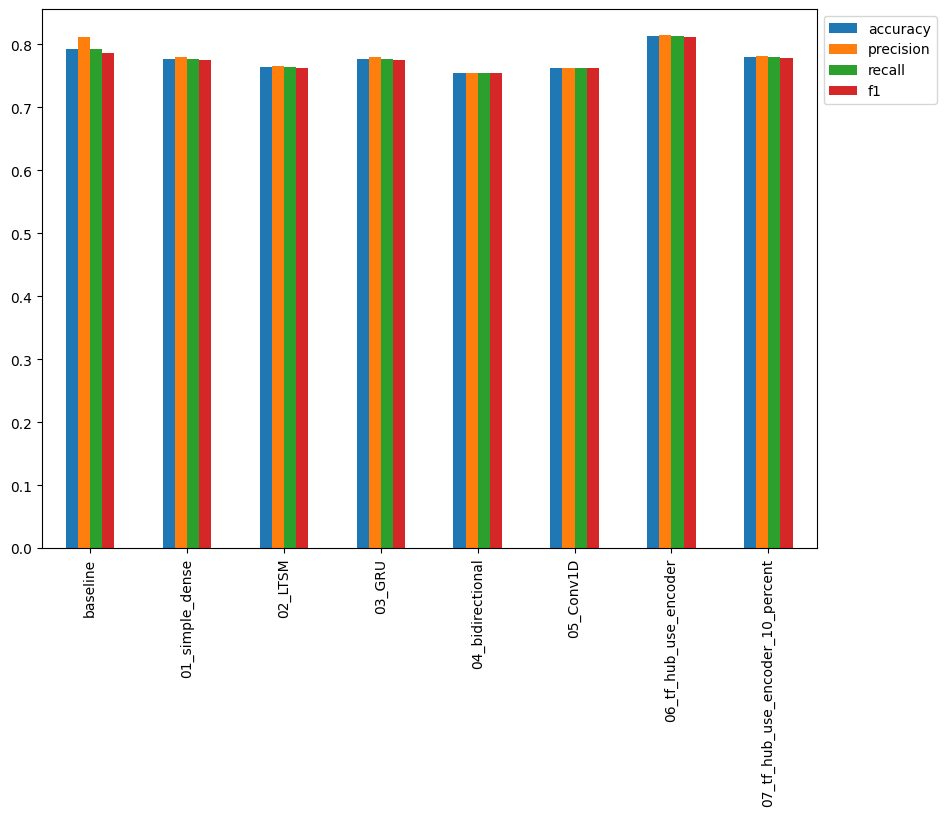

In [342]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.,1.))

<Axes: >

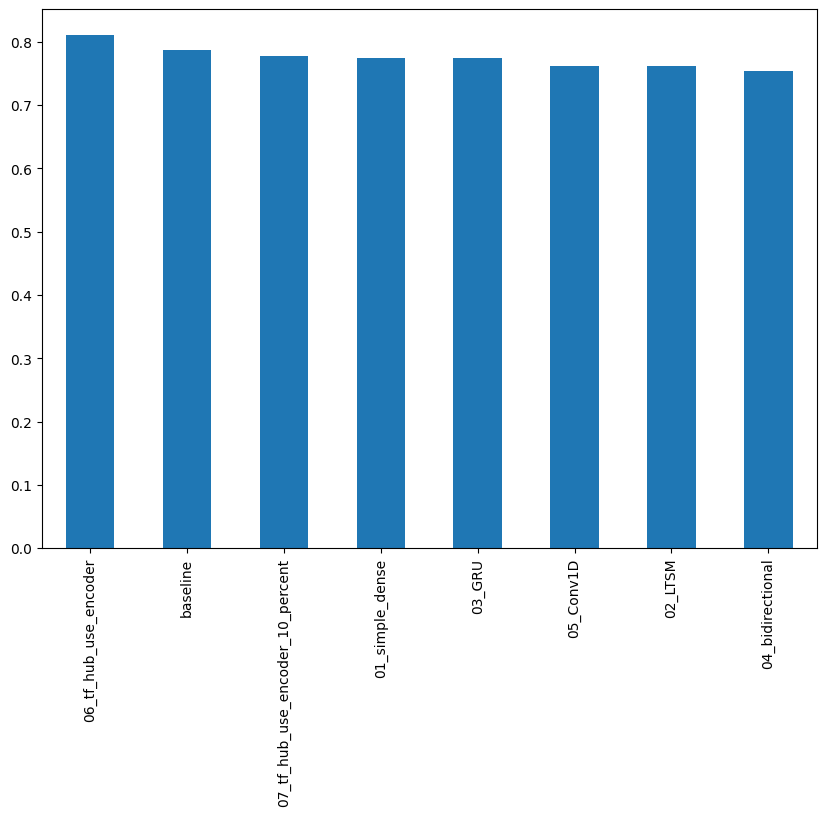

In [343]:
all_model_results.sort_values('f1',ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

In [344]:

print(keras.callbacks.TensorBoard.__module__)  # Check TensorBoard callback module

tf_keras.src.callbacks


In [345]:
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [347]:
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

In [349]:
loaded_model_6=keras.models.load_model("model_6.h5",custom_objects={"KerasLayer":hub.KerasLayer})

In [351]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

In [350]:
loaded_model_6.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4299 - accuracy: 0.8123


[0.4299352169036865, 0.8123359680175781]

In [352]:
model_6.save("model_6_savedModel_format")

In [355]:
loaded_model_6_smf = keras.models.load_model("model_6_savedModel_format")

In [356]:
loaded_model_6_smf.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4299 - accuracy: 0.8123


[0.4299352169036865, 0.8123359680175781]

In [357]:
from google.colab import files

In [358]:
files.download('./')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [360]:
files.download('./notebook.ipynb')

FileNotFoundError: Cannot find file: ./notebook.ipynb